**<center> <span style="color:Blue;font-family:Georgian; font-size:22px;">TELECOM CUSTOMER CHURN - PREDICTION</span> </center>**

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.1 Introduction</span>**
* Customer churn is a one of the biggest problem in the telecom industry. According to studies, average monthly churn rate is between 1.9% and 2.1%.
* Customers in the telecom sector have a number of service providers to pick from and can actively switch between them. In this fiercely competitive sector, the telecoms industry experiences an annual churn rate of around 22%.
* To decrease customer churn, telecom firms must identify which customers are most likely to leave. 
* The company's main priority for success is to reduce client attrition and execute an effective retention plan.
* The main objective of this project is to predict which of the customers will be loyal and which will lapse. 

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE 

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.2 Data Preparation</span>**

In [2]:
df = pd.read_csv('telco-customer-churn1.csv')
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [3]:
# Making columns names and values uniform

df.columns = df.columns.str.lower()
categorical_cols = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_cols:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [4]:
df.drop(columns='customerid', inplace=True)

In [5]:
# Customers may have just started using their sevices and may be in the middle of a trial period

df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

tc = pd.to_numeric(df.totalcharges, errors = 'coerce')
tc.isnull().sum()

0

In [6]:
df['seniorcitizen'].replace([0, 1], ['no', 'yes'], inplace=True)
df['churn'].replace(['no', 'yes'], [0, 1], inplace=True)

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.3 Train - Test Split</span>**

In [8]:
y = df['churn'].values
X = df.drop(columns = ['churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
len(X_train), len(X_test)

(5634, 1409)

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.4 One-Hot Encoding</span>**

In [10]:
encoder = ce.OneHotEncoder(cols = categorical, use_cat_names=True)

In [ ]:
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [12]:
len(X_train), len(X_test)

(5634, 1409)

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.5 Data Normalization</span>**

In [15]:
scaler = MinMaxScaler()
normalized_train_data = scaler.fit_transform(X_train)
X_train = pd.DataFrame(normalized_train_data, columns=X_train.columns)

normalized_test_data = scaler.transform(X_test)
X_test = pd.DataFrame(normalized_test_data, columns=X_test.columns)

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.6 Feature Selection: Correlation, Mutual Information</span>**

In [17]:
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: 
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [18]:
corr_features = correlation(X_train, 0.80)
corr_features = list(corr_features)

In [19]:
corr_features

['techsupport_no_internet_service',
 'onlinesecurity_no_internet_service',
 'streamingmovies_no_internet_service',
 'streamingtv_no_internet_service',
 'totalcharges',
 'onlinebackup_no_internet_service',
 'multiplelines_no_phone_service',
 'deviceprotection_no_internet_service']

In [20]:
X_train.drop(columns=corr_features, inplace=True)
X_test.drop(columns=corr_features, inplace=True)

In [ ]:
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)

In [25]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

contract_month-to-month                    0.094799
tenure                                     0.075769
contract_two_year                          0.067157
techsupport_no                             0.061588
onlinesecurity_no                          0.059079
paymentmethod_electronic_check             0.047413
internetservice_fiber_optic                0.035112
onlinebackup_no                            0.034601
monthlycharges                             0.033947
internetservice_no                         0.031718
deviceprotection_no                        0.029670
contract_one_year                          0.026616
paperlessbilling_no                        0.021657
dependents_no                              0.018904
paperlessbilling_yes                       0.017886
techsupport_yes                            0.016944
seniorcitizen_yes                          0.016673
streamingmovies_yes                        0.014080
dependents_yes                             0.013966
partner_no  

<AxesSubplot: >

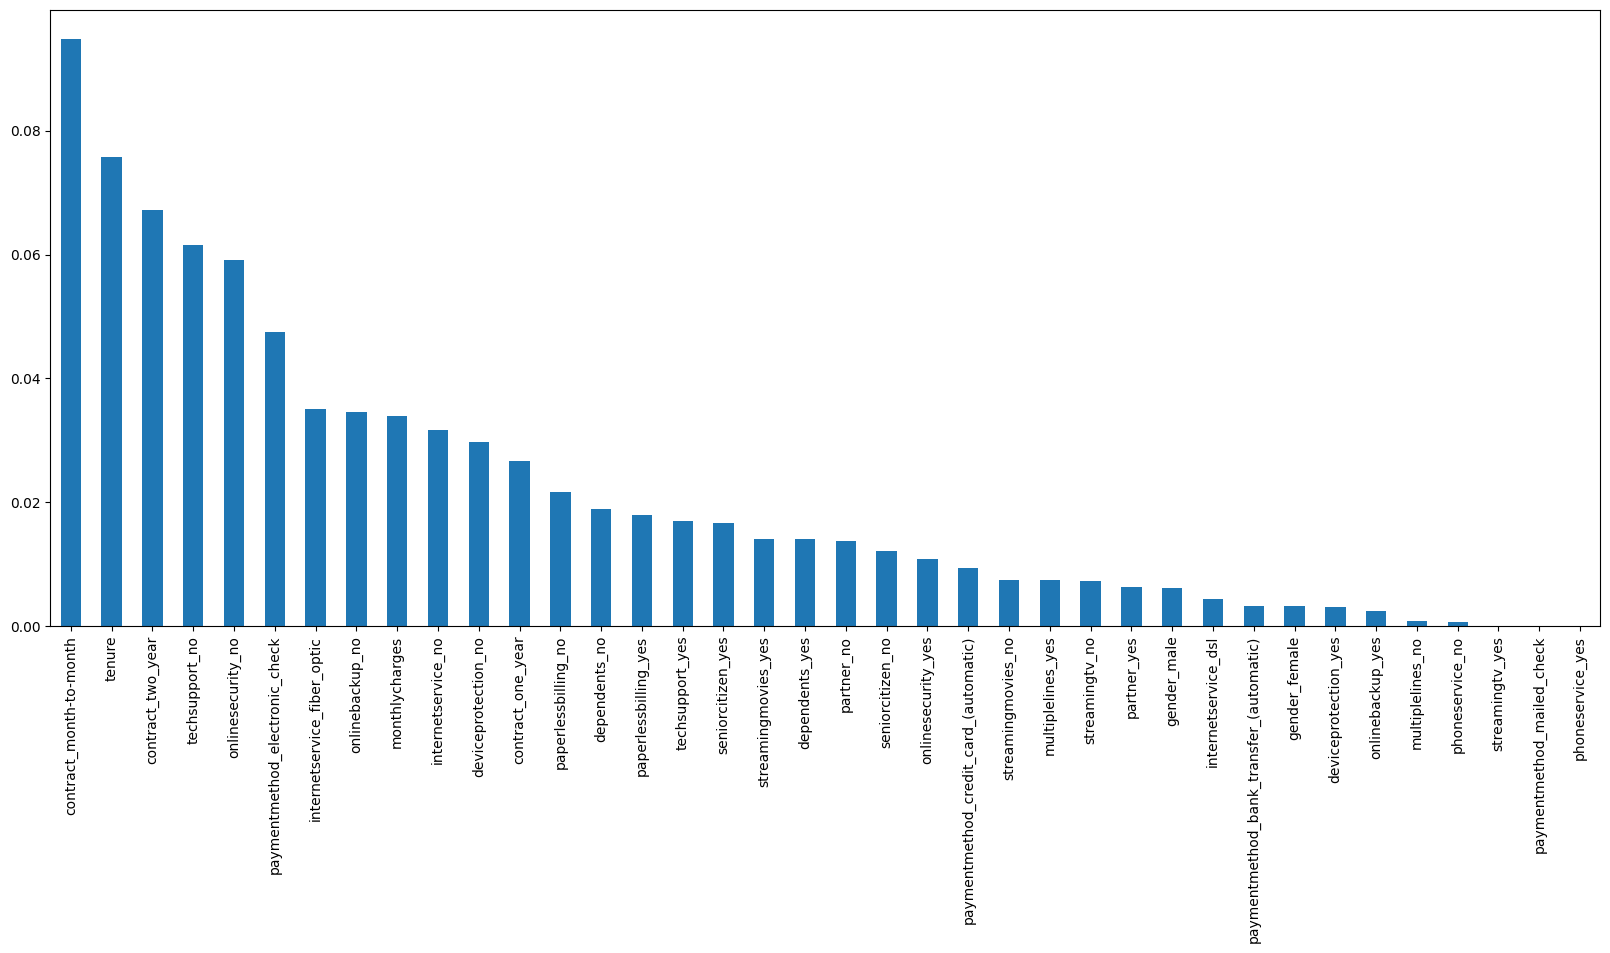

In [26]:
# ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [28]:
# select the top 25 important features
sel_cols = SelectKBest(mutual_info_classif, k=25)
sel_cols.fit(X_train, y_train)
X_train.columns[sel_cols.get_support()]

Index(['seniorcitizen_yes', 'partner_no', 'partner_yes', 'dependents_no',
       'dependents_yes', 'tenure', 'phoneservice_yes', 'internetservice_no',
       'internetservice_fiber_optic', 'onlinesecurity_no',
       'onlinesecurity_yes', 'onlinebackup_no', 'deviceprotection_no',
       'techsupport_yes', 'techsupport_no', 'contract_month-to-month',
       'contract_two_year', 'contract_one_year', 'paperlessbilling_no',
       'paperlessbilling_yes', 'paymentmethod_mailed_check',
       'paymentmethod_electronic_check',
       'paymentmethod_bank_transfer_(automatic)',
       'paymentmethod_credit_card_(automatic)', 'monthlycharges'],
      dtype='object')

In [29]:
new_columns = ['seniorcitizen_yes', 'partner_no', 'partner_yes', 'dependents_no',
                'dependents_yes', 'tenure', 'phoneservice_yes', 'internetservice_no',
                'internetservice_fiber_optic', 'onlinesecurity_no',
                'onlinesecurity_yes', 'onlinebackup_no', 'deviceprotection_no',
                'techsupport_yes', 'techsupport_no', 'contract_month-to-month',
                'contract_two_year', 'contract_one_year', 'paperlessbilling_no',
                'paperlessbilling_yes', 'paymentmethod_mailed_check',
                'paymentmethod_electronic_check',
                'paymentmethod_bank_transfer_(automatic)',
                'paymentmethod_credit_card_(automatic)', 'monthlycharges']

In [30]:
X_train.drop(columns=[col for col in X_train if col not in new_columns], inplace=True)
X_test.drop(columns=[col for col in X_test if col not in new_columns], inplace=True)

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.7 Model Building</span>**

In [35]:
models = []
models.append(('naïve_bayes', CategoricalNB()))
models.append(('logistic_regression', LogisticRegression()))
models.append(('random_forest', RandomForestClassifier()))
models.append(('xgboost', xgb.XGBClassifier()))

In [40]:
# each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model
    model.fit(X_train, y_train).predict(X_test)
    # make predictions
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append(accuracy)
    names.append(name)
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print('---------------------------------------------------------------')

Classifier: naïve_bayes, Accuracy: 0.7473385379701917)
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1043
           1       0.51      0.76      0.61       366

    accuracy                           0.75      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.75      0.76      1409

[[775 268]
 [ 88 278]]
---------------------------------------------------------------
Classifier: logistic_regression, Accuracy: 0.8126330731014905)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1043
           1       0.66      0.57      0.61       366

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409

[[936 107]
 [157 209]]
---------------------------------------------------------------
Classifier: random_forest, Accuracy: 0.790631653655074

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.8 SMOTE</span>**

In [42]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

In [43]:
y_res.mean()

0.5

In [44]:
# each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model
    model.fit(X_res, y_res).predict(X_test)
    # make predictions
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results.append(accuracy)
    names.append(name)
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print('---------------------------------------------------------------')

Classifier: naïve_bayes, Accuracy: 0.7267565649396736)
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1043
           1       0.48      0.79      0.60       366

    accuracy                           0.73      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.73      0.74      1409

[[734 309]
 [ 76 290]]
---------------------------------------------------------------
Classifier: logistic_regression, Accuracy: 0.7572746628814763)
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1043
           1       0.52      0.80      0.63       366

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.76      0.77      1409

[[775 268]
 [ 74 292]]
---------------------------------------------------------------
Classifier: random_forest, Accuracy: 0.767920511000709

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.9 Logistic Regression - Model Interpretation</span>**

In [45]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [46]:
model.intercept_[0]

-1.4261714733791062

In [48]:
model.coef_[0].round(3)

array([ 0.191, -0.004,  0.004,  0.053, -0.052, -2.259, -0.882,  0.26 ,
        0.369,  0.085, -0.345,  0.244,  0.074, -0.346,  0.087,  0.688,
       -0.595, -0.093, -0.171,  0.171, -0.081,  0.285, -0.076, -0.127,
        2.314])

In [49]:
y_pred = model.predict_proba(X_test)[:, 1]
churn_decision = (y_pred >= 0.5)

df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_test
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [50]:
df_pred.head()

,probability,prediction,actual,correct
0,0.089846,0,1,False
1,0.021170,0,0,True
2,0.154188,0,0,True
3,0.106827,0,0,True
4,0.088442,0,0,True


In [51]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_test, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.260
0.05 0.488
0.10 0.598
0.15 0.663
0.20 0.710
0.25 0.743
0.30 0.770
0.35 0.784
0.40 0.795
0.45 0.805
0.50 0.813
0.55 0.810
0.60 0.800
0.65 0.793
0.70 0.774
0.75 0.754
0.80 0.746
0.85 0.740
0.90 0.740
0.95 0.740
1.00 0.740


Text(0, 0.5, 'Accuracy Score')

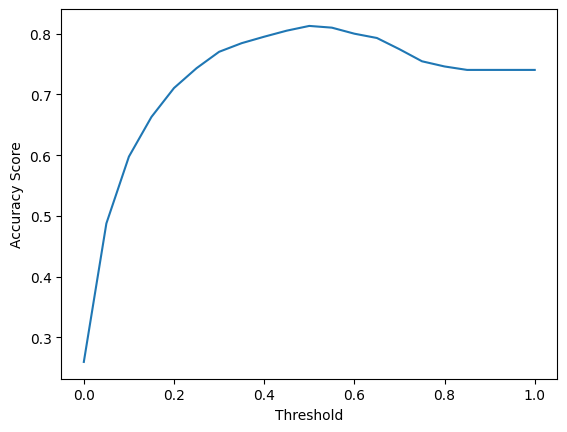

In [54]:
plt.plot(thresholds, scores)
plt.xlabel('Threshold')
plt.ylabel('Accuracy Score')

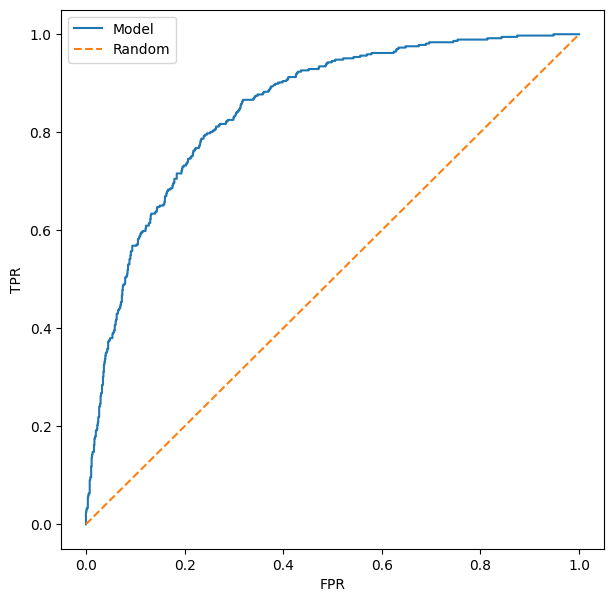

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(7, 7))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [56]:
roc_auc_score(y_test, y_pred)

0.8494451691998177

**<span style="color:Black;font-family:Georgian; font-size:20px;">2.10 Random Forest - Model Tuning</span>**

Text(0, 0.5, 'AUC Score')

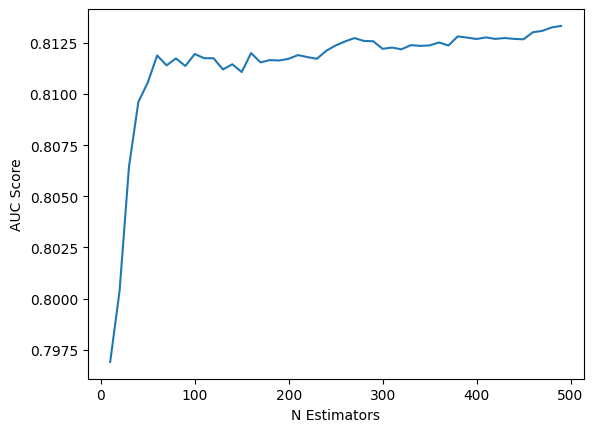

In [69]:
scores = []

for n in range(10, 500, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel('N Estimators')
plt.ylabel('AUC Score')

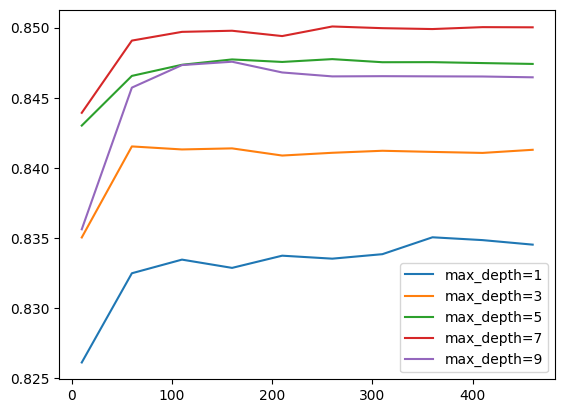

In [70]:
scores = []

for d in [1,3,5,7,9]:
    for n in range(10, 500, 50):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((d, n, auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in [1,3,5,7,9]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

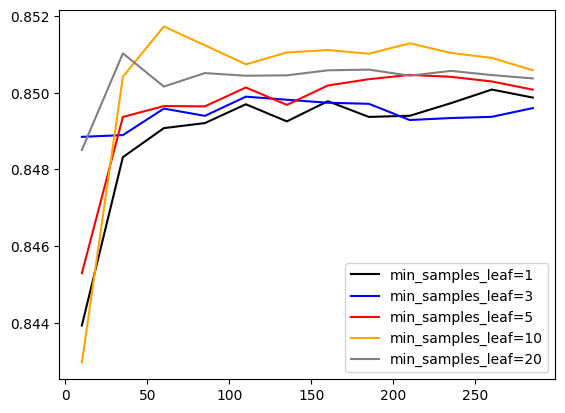

In [71]:
max_depth = 7

scores = []

for s in [1, 3, 5, 10, 20]:
    for n in range(10, 300, 25):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)

        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'red', 'orange', 'grey']
values = [1, 3, 5, 10, 20]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [92]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth,
                            min_samples_leaf=10,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_jobs=-1,
                       random_state=1)

In [93]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.67      0.52      0.59       366

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [94]:
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=7, min_samples_leaf=10, n_jobs=-1,
                       random_state=1)

In [95]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1043
           1       0.54      0.80      0.64       366

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409



In [116]:
# model tuning
param_grid = [
  {'n_estimators': [50,75,100,150,200,300],
   'max_depth': [2,4,6,8,10],
   'min_samples_leaf': [1,3,5,7,9]}
    ]
model = RandomForestClassifier()
model_gs = GridSearchCV(model,param_grid,n_jobs=-1)
model_gs.fit(X_train,y_train)
print("The best estimator is : ",model_gs.best_estimator_)

The best estimator is :  RandomForestClassifier(max_depth=6, min_samples_leaf=5, n_estimators=75)


In [118]:
rf = RandomForestClassifier(n_estimators=75,
                            max_depth=6,
                            min_samples_leaf=5,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1043
           1       0.66      0.52      0.59       366

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [121]:
rf = RandomForestClassifier(n_estimators=75,
                            max_depth=6,
                            min_samples_leaf=5,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_res, y_res)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.75      0.83      1043
           1       0.53      0.80      0.64       366

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409



**<span style="color:Black;font-family:Georgian; font-size:20px;">2.11 XGBoost - Model Tuning</span>**

In [117]:
# model tuning

param_grid_xgb = {
    'eta': [0.1, 0.2, 0.3, 0.4], 
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 10, 20]
}

model = xgb.XGBClassifier()
model_gs = GridSearchCV(model,param_grid_xgb,n_jobs=-1)
model_gs.fit(X_train,y_train)
print("The best estimator is : ",model_gs.best_estimator_)

The best estimator is :  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)


In [120]:
xgbc_h = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=10, 
              monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto')

xgbc_h.fit(X_train, y_train)
y_pred = xgbc_h.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.68      0.54      0.60       366

    accuracy                           0.81      1409
   macro avg       0.77      0.73      0.74      1409
weighted avg       0.81      0.81      0.81      1409



In [108]:
xgbc_h = xgb.XGBClassifier(eta=0.1, 
    max_depth=3,
    min_child_weight=1,
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=1,
    verbosity=1)

xgbc_h.fit(X_train, y_train)
y_pred = xgbc_h.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1043
           1       0.67      0.55      0.60       366

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409



In [109]:
xgbc_h = xgb.XGBClassifier(eta=0.1, 
    max_depth=3,
    min_child_weight=1,
    objective='binary:logistic',
    eval_metric='auc',
    nthread=8,
    seed=1,
    verbosity=1)

xgbc_h.fit(X_res, y_res)
y_pred = xgbc_h.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1043
           1       0.55      0.76      0.64       366

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409



**<span style="color:Black;font-family:Georgian; font-size:20px;">2.12 Model Selection - Best Model</span>**

In [125]:
results = pd.read_csv('results.csv')
results

,Model,SMOTE,Model Finetuning,Accuracy,Weighted Avg Recall,Macro Avg Recall
0,naïve_bayes,No,No,0.75,0.75,0.75
1,logistic_regression,No,No,0.81,0.81,0.73
2,random_forest,No,No,0.79,0.79,0.71
3,xgboost,No,No,0.79,0.79,0.70
4,naïve_bayes,Yes,No,0.73,0.73,0.75
5,logistic_regression,Yes,No,0.76,0.76,0.77
6,random_forest,Yes,No,0.77,0.77,0.72
7,xgboost,Yes,No,0.78,0.78,0.74
8,random_forest,No,Yes,0.81,0.81,0.72
9,xgboost,No,Yes,0.81,0.81,0.73


**<span style="color:Black;font-family:Georgian; font-size:20px;">2.13 Conclusion</span>**

* There is slight improvement in recall when SMOTE is used but overall accuracy drops slightly which is ok.
* Pre SMOTE Naïve Bayes performs best.